<a href="https://colab.research.google.com/github/kojiyam/denso/blob/master/denso02_distributed_power_control_jp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries with common settings

In [1]:
import numpy as np
np.random.seed(1)
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
#plt.style.use('dark_background')  # For dark mode
plt.rcParams["font.size"] = 16   # Font size in figures

## Parameters

In [2]:
N = 4 # Number of Tx-Rx pairs
LENGTH = 1000 # (m), LENGTH x LENGTH の正方形．原点中心
MAX_DIST = 100 # (m) 各Tx-Rxペアの距離は，DIST
LAMBDA = 0.3 # (m) Wave length of carrier
SINR_REQ = 4 # Required SINR (in linear scale not dB)． 共通とした
NOISE = 10**((-174 + 70 + 10)/10) # (in linear scale) 10 MHz = 70 dBHz, Noise figure 10 dB． 共通とした

## Binomial networks

In [3]:
# Random number generation
tx = np.random.rand(2*N).reshape(N,2) * LENGTH - LENGTH/2
dist = MAX_DIST * np.random.rand(N)
theta = 2 * np.pi * np.random.rand(N)
rx = tx + np.array([ dist * np.cos(theta), dist * np.sin(theta) ]).T

$ \{ \mathrm{Tx}_j \}_{j=1,\dots,n} $ is a binomial point process over $ \{ (x,y) \in \mathbb{R}^2 : \lvert x \rvert \leq \mathrm{LENGTH}/2 , \lvert y \rvert \leq \mathrm{LENGTH}/2 \} $

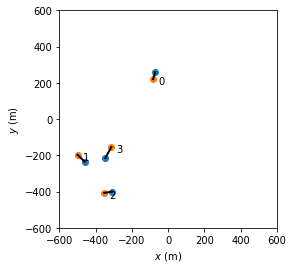

In [4]:
# Visibilitization
fig, ax = plt.subplots()
ax.set_xlim(-LENGTH/2-MAX_DIST,LENGTH/2+MAX_DIST)
ax.set_ylim(-LENGTH/2-MAX_DIST,LENGTH/2+MAX_DIST)
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
ax.set_aspect('equal', adjustable='box')
plt.plot([tx[:,0], rx[:,0]], [tx[:,1], rx[:,1]], color='black', linewidth=2)
plt.scatter(rx[:,0], rx[:,1], label="RX")
plt.scatter(tx[:,0], tx[:,1], label="TX")
for i in range(N):
  ax.annotate(i, (tx[i,0]+30, tx[i,1]-30))
#plt.tight_layout()
plt.show()

In [5]:
d = distance_matrix(rx, tx)
G = np.power(LAMBDA / ( 4 * np.pi * d ), 2)
eta = SINR_REQ * NOISE / np.diag(G).reshape(N,1) # 明示的に縦ベクトル（1列の行列）に
F = np.zeros((N,N))
for i in range(N):
  F[i,:] = SINR_REQ * G[i,:] / G[i,i]
  F[i,i] = 0

$ d_{ij} := | \mathrm{Rx}_i - \mathrm{Tx}_j | $

$ G_{ij} = ({\lambda}/{ 4 \pi d_{ij}})^2 $

$ \eta_i = \varGamma_i {\sigma_i}^2 / G_{ii} $

$ f_{ij} = (\varGamma_i G_{ij} / G_{ii} ) \, \mathbf{1}( i \neq j) $




## Perron-Frobenius eigenvalue (maximum eigenvalue) of $F$

In [6]:
print( np.max( np.linalg.eigvals(F) ) )

0.6924001236659827


## Optimal transmission power

In [7]:
I = np.identity(N)
# p_opt = np.linalg.inv(I-F) @ eta
p_opt = np.linalg.inv(I-F) @ eta

$ \boldsymbol{p}^\star = ( \boldsymbol{I}- \boldsymbol{F})^{-1} \boldsymbol{\eta} $

In [8]:
print(p_opt)

[[0.00623294]
 [0.02987429]
 [0.01281911]
 [0.04360564]]


## Foschini-Miljanic algorithm

In [9]:
LOOP = 10
p = np.zeros(N*(LOOP+1)).reshape(N, LOOP+1)

for k in range(LOOP):
  p[:,k+1] = ( F @ p[:,k].reshape(N,1) + eta ).reshape(-1,N)

$ \boldsymbol{p}[k+1] = \boldsymbol{F} \boldsymbol{p}[k] + \boldsymbol{\eta} $

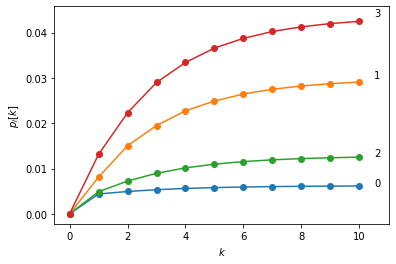

In [10]:
# Visibilitization
x_min = LOOP
x_max = LOOP+0.5
fig, ax = plt.subplots()
plt.xlabel(r"$k$")
plt.ylabel(r"$p_i[k]$")
plt.xticks(np.arange(0, 11, 2))
for i in range(N):
  plt.hlines([p_opt[i]], x_min, x_max, "white", linestyle="dashed")
  plt.plot(p[i,:], marker='o', label=i)
  ax.annotate(i, (x_max, p_opt[i]))
#plt.legend()

## 補足

`eta` は明示的に縦ベクトルにする必要はなく，以下のようにしても同じ

```
eta = SINR_REQ * NOISE / np.diag(G)
p_opt = np.linalg.inv(I-F) @ eta
```



## 参考

2020 Mitsuki Ito, Shunnosuke Kotera, Misaki Udo